# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV


# Config

In [2]:
INPUT_PATH = '../../data/labels.parquet'
OUTPUT_PATH = '../../results/with_two_week_features/xgb_predictions.parquet'
RIDGE_PATH = '../../ridge/with_two_week_features/'

FEATURE_LIST = [
    # 'Day_of_month','Day_of_week',
    'Previous_week_demand',
    'Previous_2week_demand',
    'Relative_previous_day_demand',
    'Relative_previous_2day_demand',
    'Relative_previous_3day_demand',
    'Relative_previous_4day_demand',
    'Relative_previous_5day_demand',
    'Relative_previous_6day_demand',
    'Relative_previous_8day_demand',
    'Relative_previous_9day_demand',
    'Relative_previous_10day_demand',
    'Relative_previous_11day_demand',
    'Relative_previous_12day_demand',
    'Relative_previous_13day_demand',
    'Relative_ridge_demand']

TEST_START_DATE = '2023-04-01'

AUTO_TUNE = False

# Loading Dataset

In [3]:
def load_data(path):
    df = pd.read_parquet(path) 
    return df

In [4]:
rides_df = load_data(INPUT_PATH)
print(f'rides_df shape : {rides_df.shape}')
rides_df.head()

rides_df shape : (31440, 3)


,Location,Date,Demand
0,1,2023-01-01,40.0
1,1,2023-01-02,31.0
2,1,2023-01-03,27.0
3,1,2023-01-04,7.0
4,1,2023-01-05,15.0


In [5]:
ridge_df = (
    load_data(RIDGE_PATH)
    .sort_values(['Location', 'Date'], ascending=[True, True])
    .reset_index(drop=True)
    )

ridge_df['Relative_ridge_demand'] = (
    ridge_df['Predicted_demand']
    /ridge_df.groupby(['Location'])['Predicted_demand'].shift(7)
    )

print(f'ridge_df shape : {ridge_df.shape}')
ridge_df.head()

ridge_df shape : (27772, 4)


,Location,Date,Predicted_demand,Relative_ridge_demand
0,1,2023-01-15,20.538611,NaN
1,1,2023-01-16,26.080705,NaN
2,1,2023-01-17,17.299049,NaN
3,1,2023-01-18,14.061910,NaN
4,1,2023-01-19,13.346132,NaN


# Feature engineering

In [6]:
def feature_engineering(dataset):    
    dataset['Previous_week_demand'] = dataset.groupby(['Location'])['Demand'].shift(7)
    dataset['Previous_2week_demand'] = dataset.groupby(['Location'])['Demand'].shift(14)  
      
    dataset['Previous_day_demand'] = dataset.groupby(['Location'])['Demand'].shift(1)
    dataset['Relative_previous_day_demand'] = (
        dataset.groupby(['Location'])['Demand'].shift(1)
        /dataset.groupby(['Location'])['Demand'].shift(8)
        )
    
    dataset['Previous_2day_demand'] = dataset.groupby(['Location'])['Demand'].shift(2)
    dataset['Relative_previous_2day_demand'] = (
        dataset.groupby(['Location'])['Demand'].shift(2)
        /dataset.groupby(['Location'])['Demand'].shift(9)
        )
    
    dataset['Previous_3day_demand'] = dataset.groupby(['Location'])['Demand'].shift(3)
    dataset['Relative_previous_3day_demand'] = (
        dataset.groupby(['Location'])['Demand'].shift(3)
        /dataset.groupby(['Location'])['Demand'].shift(10)
        )
    
    dataset['Previous_4day_demand'] = dataset.groupby(['Location'])['Demand'].shift(4)
    dataset['Relative_previous_4day_demand'] = (
        dataset.groupby(['Location'])['Demand'].shift(4)
        /dataset.groupby(['Location'])['Demand'].shift(11)
        )
    
    dataset['Previous_5day_demand'] = dataset.groupby(['Location'])['Demand'].shift(5)
    dataset['Relative_previous_5day_demand'] = (
        dataset.groupby(['Location'])['Demand'].shift(5)
        /dataset.groupby(['Location'])['Demand'].shift(12)
        )
    
    dataset['Previous_6day_demand'] = dataset.groupby(['Location'])['Demand'].shift(6)
    dataset['Relative_previous_6day_demand'] = (
        dataset.groupby(['Location'])['Demand'].shift(6)
        /dataset.groupby(['Location'])['Demand'].shift(13)
        )
    
    dataset['Previous_8day_demand'] = dataset.groupby(['Location'])['Demand'].shift(8)
    dataset['Relative_previous_8day_demand'] = (
        dataset.groupby(['Location'])['Demand'].shift(8)
        /dataset.groupby(['Location'])['Demand'].shift(15)
        )
    
    dataset['Previous_9day_demand'] = dataset.groupby(['Location'])['Demand'].shift(9)
    dataset['Relative_previous_9day_demand'] = (
        dataset.groupby(['Location'])['Demand'].shift(9)
        /dataset.groupby(['Location'])['Demand'].shift(16)
        )
    
    dataset['Previous_10day_demand'] = dataset.groupby(['Location'])['Demand'].shift(10)
    dataset['Relative_previous_10day_demand'] = (
        dataset.groupby(['Location'])['Demand'].shift(10)
        /dataset.groupby(['Location'])['Demand'].shift(17)
        )
    
    dataset['Previous_11day_demand'] = dataset.groupby(['Location'])['Demand'].shift(11)
    dataset['Relative_previous_11day_demand'] = (
        dataset.groupby(['Location'])['Demand'].shift(11)
        /dataset.groupby(['Location'])['Demand'].shift(18)
        )
    
    dataset['Previous_12day_demand'] = dataset.groupby(['Location'])['Demand'].shift(12)
    dataset['Relative_previous_12day_demand'] = (
        dataset.groupby(['Location'])['Demand'].shift(12)
        /dataset.groupby(['Location'])['Demand'].shift(19)
        )
    
    dataset['Previous_13day_demand'] = dataset.groupby(['Location'])['Demand'].shift(13)
    dataset['Relative_previous_13day_demand'] = (
        dataset.groupby(['Location'])['Demand'].shift(13)
        /dataset.groupby(['Location'])['Demand'].shift(20)
        )
    dataset['Day_of_week'] = dataset['Date'].dt.dayofweek   
    dataset['Day_of_month'] = dataset['Date'].dt.day
    return dataset

In [7]:
features_df = feature_engineering(rides_df)
print(f'features_df shape : {features_df.shape}')
features_df.head()

features_df shape : (31440, 31)


,Location,Date,Demand,Previous_week_demand,Previous_2week_demand,Previous_day_demand,Relative_previous_day_demand,Previous_2day_demand,Relative_previous_2day_demand,Previous_3day_demand,...,Previous_10day_demand,Relative_previous_10day_demand,Previous_11day_demand,Relative_previous_11day_demand,Previous_12day_demand,Relative_previous_12day_demand,Previous_13day_demand,Relative_previous_13day_demand,Day_of_week,Day_of_month
0,1,2023-01-01,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,1
1,1,2023-01-02,31.0,NaN,NaN,40.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2
2,1,2023-01-03,27.0,NaN,NaN,31.0,NaN,40.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3
3,1,2023-01-04,7.0,NaN,NaN,27.0,NaN,31.0,NaN,40.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,4
4,1,2023-01-05,15.0,NaN,NaN,7.0,NaN,27.0,NaN,31.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,5


In [8]:
# features_df[features_df == np.inf].count()

## Fill inf

In [ ]:
inf_index_day = features_df[features_df['Relative_previous_day_demand'] == np.inf].index
features_df['Relative_previous_day_demand'].loc[inf_index_day] = features_df['Previous_day_demand'].loc[inf_index_day]

inf_index_2day = features_df[features_df['Relative_previous_2day_demand'] == np.inf].index
features_df['Relative_previous_2day_demand'].loc[inf_index_2day] = features_df['Previous_2day_demand'].loc[inf_index_2day]

inf_index_3day = features_df[features_df['Relative_previous_3day_demand'] == np.inf].index
features_df['Relative_previous_3day_demand'].loc[inf_index_3day] = features_df['Previous_3day_demand'].loc[inf_index_3day]

inf_index_4day = features_df[features_df['Relative_previous_4day_demand'] == np.inf].index
features_df['Relative_previous_4day_demand'].loc[inf_index_4day] = features_df['Previous_4day_demand'].loc[inf_index_4day]

inf_index_5day = features_df[features_df['Relative_previous_5day_demand'] == np.inf].index
features_df['Relative_previous_5day_demand'].loc[inf_index_5day] = features_df['Previous_5day_demand'].loc[inf_index_5day]

inf_index_6day = features_df[features_df['Relative_previous_6day_demand'] == np.inf].index
features_df['Relative_previous_6day_demand'].loc[inf_index_6day] = features_df['Previous_6day_demand'].loc[inf_index_6day]

inf_index_8day = features_df[features_df['Relative_previous_8day_demand'] == np.inf].index
features_df['Relative_previous_8day_demand'].loc[inf_index_8day] = features_df['Previous_8day_demand'].loc[inf_index_8day]

inf_index_9day = features_df[features_df['Relative_previous_9day_demand'] == np.inf].index
features_df['Relative_previous_9day_demand'].loc[inf_index_9day] = features_df['Previous_9day_demand'].loc[inf_index_9day]

inf_index_10day = features_df[features_df['Relative_previous_10day_demand'] == np.inf].index
features_df['Relative_previous_10day_demand'].loc[inf_index_10day] = features_df['Previous_10day_demand'].loc[inf_index_10day]

inf_index_11day = features_df[features_df['Relative_previous_11day_demand'] == np.inf].index
features_df['Relative_previous_11day_demand'].loc[inf_index_11day] = features_df['Previous_11day_demand'].loc[inf_index_11day]

inf_index_12day = features_df[features_df['Relative_previous_12day_demand'] == np.inf].index
features_df['Relative_previous_12day_demand'].loc[inf_index_12day] = features_df['Previous_12day_demand'].loc[inf_index_12day]

inf_index_13day = features_df[features_df['Relative_previous_13day_demand'] == np.inf].index
features_df['Relative_previous_13day_demand'].loc[inf_index_13day] = features_df['Previous_13day_demand'].loc[inf_index_13day]

In [10]:
# features_df[features_df == np.inf].count()

In [11]:
features_df.fillna(value=0, inplace=True)

print(features_df.shape)
features_df.head()

(31440, 31)


,Location,Date,Demand,Previous_week_demand,Previous_2week_demand,Previous_day_demand,Relative_previous_day_demand,Previous_2day_demand,Relative_previous_2day_demand,Previous_3day_demand,...,Previous_10day_demand,Relative_previous_10day_demand,Previous_11day_demand,Relative_previous_11day_demand,Previous_12day_demand,Relative_previous_12day_demand,Previous_13day_demand,Relative_previous_13day_demand,Day_of_week,Day_of_month
0,1,2023-01-01,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,1
1,1,2023-01-02,31.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2
2,1,2023-01-03,27.0,0.0,0.0,31.0,0.0,40.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3
3,1,2023-01-04,7.0,0.0,0.0,27.0,0.0,31.0,0.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,4
4,1,2023-01-05,15.0,0.0,0.0,7.0,0.0,27.0,0.0,31.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,5


In [12]:
final_features_df = (
    features_df
    .merge(ridge_df.filter(items=['Location', 'Date', 'Relative_ridge_demand']), how='left', on=['Location', 'Date'])
    .rename(columns = {'Predicted_demand':'Ridge_predict'})
    )

final_features_df.dropna(inplace=True)

print(f'final_features_df shape : {final_features_df.shape}')
final_features_df.head()

final_features_df shape : (25938, 32)


,Location,Date,Demand,Previous_week_demand,Previous_2week_demand,Previous_day_demand,Relative_previous_day_demand,Previous_2day_demand,Relative_previous_2day_demand,Previous_3day_demand,...,Relative_previous_10day_demand,Previous_11day_demand,Relative_previous_11day_demand,Previous_12day_demand,Relative_previous_12day_demand,Previous_13day_demand,Relative_previous_13day_demand,Day_of_week,Day_of_month,Relative_ridge_demand
21,1,2023-01-22,11.0,19.0,12.0,9.0,1.285714,20.0,0.952381,9.0,...,0.533333,9.0,1.285714,4.0,0.148148,14.0,0.451613,6,22,0.653708
22,1,2023-01-23,6.0,21.0,14.0,11.0,0.578947,9.0,1.285714,20.0,...,1.909091,8.0,0.533333,9.0,1.285714,4.0,0.148148,0,23,0.599131
23,1,2023-01-24,6.0,18.0,4.0,6.0,0.285714,11.0,0.578947,9.0,...,1.166667,21.0,1.909091,8.0,0.533333,9.0,1.285714,1,24,0.357756
24,1,2023-01-25,7.0,10.0,9.0,6.0,0.333333,6.0,0.285714,11.0,...,1.583333,7.0,1.166667,21.0,1.909091,8.0,0.533333,2,25,0.185419
25,1,2023-01-26,7.0,9.0,8.0,7.0,0.700000,6.0,0.333333,6.0,...,1.500000,19.0,1.583333,7.0,1.166667,21.0,1.909091,3,26,0.319172


In [13]:
# final_features_df[final_features_df == np.inf].count()

In [14]:
# final_features_df.isna().sum()

In [15]:
pca = PCA()
pca.fit(final_features_df[FEATURE_LIST])


cumsum = np.cumsum(pca.explained_variance_ratio_)
cumsum, len(FEATURE_LIST), pca.feature_names_in_

(array([0.96254384, 0.99633522, 0.99999503, 0.99999601, 0.99999649,
        0.99999696, 0.99999742, 0.99999787, 0.99999832, 0.99999877,
        0.99999904, 0.9999993 , 0.99999955, 0.99999978, 1.        ]),
 15,
 array(['Previous_week_demand', 'Previous_2week_demand',
        'Relative_previous_day_demand', 'Relative_previous_2day_demand',
        'Relative_previous_3day_demand', 'Relative_previous_4day_demand',
        'Relative_previous_5day_demand', 'Relative_previous_6day_demand',
        'Relative_previous_8day_demand', 'Relative_previous_9day_demand',
        'Relative_previous_10day_demand', 'Relative_previous_11day_demand',
        'Relative_previous_12day_demand', 'Relative_previous_13day_demand',
        'Relative_ridge_demand'], dtype=object))

# Modeling

## Split Train and Test Data

In [16]:
def train_test_splitting(dataset, TEST_START_DATE):

    train_df = dataset[dataset['Date'] < TEST_START_DATE]
    test_df = dataset[dataset['Date'] >= TEST_START_DATE]

    return train_df, test_df

In [17]:
train_df, test_df = train_test_splitting(final_features_df, TEST_START_DATE)

In [18]:
print(f'train_df shape : {train_df.shape}')
train_df.head()

train_df shape : (18078, 32)


,Location,Date,Demand,Previous_week_demand,Previous_2week_demand,Previous_day_demand,Relative_previous_day_demand,Previous_2day_demand,Relative_previous_2day_demand,Previous_3day_demand,...,Relative_previous_10day_demand,Previous_11day_demand,Relative_previous_11day_demand,Previous_12day_demand,Relative_previous_12day_demand,Previous_13day_demand,Relative_previous_13day_demand,Day_of_week,Day_of_month,Relative_ridge_demand
21,1,2023-01-22,11.0,19.0,12.0,9.0,1.285714,20.0,0.952381,9.0,...,0.533333,9.0,1.285714,4.0,0.148148,14.0,0.451613,6,22,0.653708
22,1,2023-01-23,6.0,21.0,14.0,11.0,0.578947,9.0,1.285714,20.0,...,1.909091,8.0,0.533333,9.0,1.285714,4.0,0.148148,0,23,0.599131
23,1,2023-01-24,6.0,18.0,4.0,6.0,0.285714,11.0,0.578947,9.0,...,1.166667,21.0,1.909091,8.0,0.533333,9.0,1.285714,1,24,0.357756
24,1,2023-01-25,7.0,10.0,9.0,6.0,0.333333,6.0,0.285714,11.0,...,1.583333,7.0,1.166667,21.0,1.909091,8.0,0.533333,2,25,0.185419
25,1,2023-01-26,7.0,9.0,8.0,7.0,0.700000,6.0,0.333333,6.0,...,1.500000,19.0,1.583333,7.0,1.166667,21.0,1.909091,3,26,0.319172


In [19]:
print(f'test_df shape : {test_df.shape}')
test_df.head()

test_df shape : (7860, 32)


,Location,Date,Demand,Previous_week_demand,Previous_2week_demand,Previous_day_demand,Relative_previous_day_demand,Previous_2day_demand,Relative_previous_2day_demand,Previous_3day_demand,...,Relative_previous_10day_demand,Previous_11day_demand,Relative_previous_11day_demand,Previous_12day_demand,Relative_previous_12day_demand,Previous_13day_demand,Relative_previous_13day_demand,Day_of_week,Day_of_month,Relative_ridge_demand
90,1,2023-04-01,13.0,15.0,25.0,13.0,1.444444,13.0,0.619048,7.0,...,1.800000,6.0,0.428571,14.0,1.076923,33.0,1.650000,5,1,1.552017
91,1,2023-04-02,17.0,14.0,33.0,13.0,0.866667,13.0,1.444444,13.0,...,1.750000,9.0,1.800000,6.0,0.428571,14.0,1.076923,6,2,1.296374
92,1,2023-04-03,9.0,3.0,14.0,17.0,1.214286,13.0,0.866667,13.0,...,0.500000,21.0,1.750000,9.0,1.800000,6.0,0.428571,0,3,2.980320
93,1,2023-04-04,12.0,14.0,6.0,9.0,3.000000,17.0,1.214286,13.0,...,0.600000,9.0,0.500000,21.0,1.750000,9.0,1.800000,1,4,11.346536
94,1,2023-04-05,18.0,7.0,9.0,12.0,0.857143,9.0,3.000000,17.0,...,0.424242,15.0,0.600000,9.0,0.500000,21.0,1.750000,2,5,2.950794


## Gradient Boosting Regressor

### Model Tuning

In [20]:
def grid_search(model, test_parameters, train_data, feature_list, cv = None):
    gs = GridSearchCV(
        estimator = model, 
        param_grid = test_parameters, 
        scoring = 'neg_root_mean_squared_error', 
        cv = cv, 
        n_jobs = -1
        )
    
    gs.fit(train_data[feature_list], train_data['Demand'])
    return gs.best_params_, gs.best_score_

In [21]:
if AUTO_TUNE:
    params_test = {
                'learning_rate':[0.15, 0.1, 0.05], 
                'subsample':[0.7, 0.8, 0.9], 
                'colsample_bytree':[0.6, 0.7, 0.8], 
                'max_depth':[4, 5, 6], 
                'min_child_weight':[10, 20, 30],
                }
    params = {"objective": "reg:squarederror"}

    best_params, best_score = grid_search(
        model = xgb.XGBRegressor(**params), 
        test_parameters = params_test,
        train_data = train_df, 
        feature_list = FEATURE_LIST, 
        cv = 3
        )
    
    print(best_params, best_score)
    
else:
    best_params = {
        'colsample_bytree': 0.8, 
        'learning_rate': 0.05, 
        'max_depth': 6, 
        'min_child_weight': 20, 
        'subsample': 0.7
        }

{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 20, 'subsample': 0.7} -94.23161998151052


### Prediction

In [22]:
def model_predict(model, train_data, test_data, feature_list):

    model.fit(train_data[feature_list], train_data['Demand'])
    train_predict_df = model.predict(train_data[feature_list])
    test_predict_df = model.predict(test_data[feature_list])

    return train_predict_df, test_predict_df

In [23]:
model = xgb.XGBRegressor(**best_params)
train_prediction_df, test_prediction_df = model_predict(model, train_df, test_df, FEATURE_LIST)

### Visualization

In [24]:
def prediction_visualization(train_data, test_data, train_prediction_df, test_prediction_df):
    
    train_data['Day_of_year'] = train_data['Date'].dt.dayofyear
    test_data['Day_of_year'] = test_data['Date'].dt.dayofyear
    
    predicted_train_df = train_data
    predicted_test_df = test_data
    predicted_train_df['Predicted'] = train_prediction_df
    predicted_test_df['Predicted'] = test_prediction_df

    train_data = train_data.groupby('Day_of_year')['Demand'].sum()
    test_data = test_data.groupby('Day_of_year')['Demand'].sum()
    predicted_train_df = predicted_train_df.groupby('Day_of_year')['Predicted'].sum()
    predicted_test_df = predicted_test_df.groupby('Day_of_year')['Predicted'].sum()

    plt.title('Train')
    plt.plot(train_data)
    plt.plot(predicted_train_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()

    plot_length = len(test_data)
    plt.title('Test')
    plt.plot(test_data)
    plt.plot(predicted_test_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()


C:\Users\NPC\AppData\Local\Temp\ipykernel_8968\3296751654.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Day_of_year'] = train_data['Date'].dt.dayofyear
C:\Users\NPC\AppData\Local\Temp\ipykernel_8968\3296751654.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Day_of_year'] = test_data['Date'].dt.dayofyear
C:\Users\NPC\AppData\Local\Temp\ipykernel_8968\3296751654.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

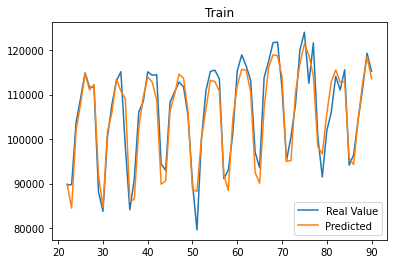

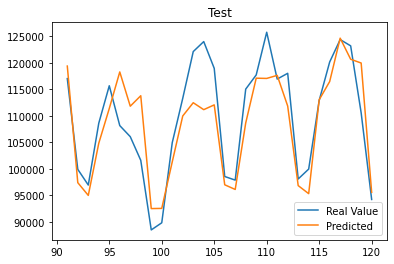

In [25]:
prediction_visualization(train_df, test_df, train_prediction_df, test_prediction_df)

### Evaluation

In [26]:
def evaluate(metric, metric_name, true_values, predicted_values):
    print(f'{metric_name} : {metric(true_values, predicted_values)}')

In [27]:
def evaluation(model_name, train_df, test_df, train_prediction_df, test_prediction_df):
    print(f'{model_name} train scores:')

    evaluate(mean_absolute_error, 'MAE', train_df['Demand'], train_prediction_df)
    evaluate(mean_squared_error, 'MSE', train_df['Demand'], train_prediction_df)
    # evaluate(mean_absolute_percentage_error, 'MAPE', train_df['Demand'], train_prediction_df)

    print(f'\n{model_name} test scores:')

    evaluate(mean_absolute_error, 'MAE', test_df['Demand'], test_prediction_df)
    evaluate(mean_squared_error, 'MSE', test_df['Demand'], test_prediction_df)
    # evaluate(mean_absolute_percentage_error, 'MAPE', test_df['Demand'], test_prediction_df)

In [28]:
evaluation('XGB', train_df, test_df, train_prediction_df, test_prediction_df)

XGB train scores:
MAE : 24.174037252782263
MSE : 5063.911830138736

XGB test scores:
MAE : 32.90530328719412
MSE : 9596.084858148912


### Feature Importance and SHAPE

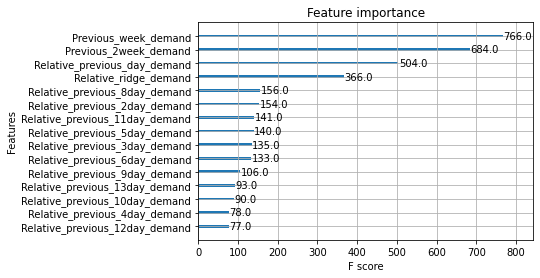

In [29]:
xgb.plot_importance(model)
plt.show()

# File saving

In [30]:
def save_predictions(dataset, path):
    dataset.to_parquet(path, index=False)

In [31]:
def prediction_labeling(pred_df, labeled_df):
    pred_df = pd.DataFrame(pred_df, columns = ['Predicted_demand'])
    labeled_df.reset_index(inplace = True)
    labeled_prediction_df = labeled_df[['Location', 'Date']]
    labeled_prediction_df['Predicted_demand'] = pred_df
    return labeled_prediction_df

In [32]:
labeled_prediction_df = prediction_labeling(test_prediction_df, test_df)
print(f'labeled_prediction_df shape : {labeled_prediction_df.shape}')
labeled_prediction_df.head()

labeled_prediction_df shape : (7860, 3)


C:\Users\NPC\AppData\Local\Temp\ipykernel_8968\1857597426.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_prediction_df['Predicted_demand'] = pred_df


,Location,Date,Predicted_demand
0,1,2023-04-01,16.029966
1,1,2023-04-02,19.037487
2,1,2023-04-03,7.464077
3,1,2023-04-04,8.989044
4,1,2023-04-05,5.295720


In [33]:
save_predictions(labeled_prediction_df, OUTPUT_PATH)